In [1]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import glob
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split # Added random_split
import time


# --- Configuration ---

# Path to the full ImageNet training set on Sol
IMAGENET_TRAIN_PATH = '/data/datasets/community/deeplearning/imagenet/train'

# Path to the label mapping file you provided
LABEL_MAP_FILE = './map_clsloc.txt'

# Path where you want to create your new prototype dataset
# This will create a new folder named 'imagenet_prototype' in your current directory
PROTOTYPE_PATH = './imagenet_prototype'

# --- Subset Parameters ---
# We will select 50 random classes
NUM_CLASSES_TO_SELECT = 50

# We will select 100 random images from each of those classes
NUM_SAMPLES_PER_CLASS = 100

# Set a random seed for reproducibility
random.seed(42)

print(f"Full ImageNet path: {IMAGENET_TRAIN_PATH}")
print(f"Prototype dataset will be created at: {PROTOTYPE_PATH}")
print(f"Will select {NUM_CLASSES_TO_SELECT} classes with {NUM_SAMPLES_PER_CLASS} images each.")

Full ImageNet path: /data/datasets/community/deeplearning/imagenet/train
Prototype dataset will be created at: ./imagenet_prototype
Will select 50 classes with 100 images each.


In [2]:
def load_label_map(map_file_path):
    """
    Parses the map_clsloc.txt file.
    
    Returns:
        A dictionary mapping {wnid: class_name}
    """
    wnid_to_name = {}
    if not os.path.exists(map_file_path):
        print(f"Error: Label map file not found at {map_file_path}")
        return None

    with open(map_file_path, 'r') as f:
        for line in f:
            # Splits into max 3 parts: ['wnid', 'label_id', 'class_name']
            parts = line.strip().split(maxsplit=2) 
            
            if len(parts) == 3:
                wnid, label_id, class_name = parts
                wnid_to_name[wnid] = class_name
            # else: line is malformed, so we skip it.
            
    print(f"Successfully loaded {len(wnid_to_name)} class names from {map_file_path}")
    return wnid_to_name

# Load the map
wnid_to_name_map = load_label_map(LABEL_MAP_FILE)

# Peek at a few loaded class names
if wnid_to_name_map:
    print("\n--- Example Class Names ---")
    example_wnids = list(wnid_to_name_map.keys())[0:5]
    for wnid in example_wnids:
        print(f"{wnid}: {wnid_to_name_map[wnid]}")

Successfully loaded 1000 class names from ./map_clsloc.txt

--- Example Class Names ---
n02119789: kit_fox
n02100735: English_setter
n02110185: Siberian_husky
n02096294: Australian_terrier
n02102040: English_springer


In [3]:
# This list will store stats for our final report
subset_stats = []

# --- 1. Get all available class directories ---
try:
    all_class_dirs = [d for d in os.listdir(IMAGENET_TRAIN_PATH) 
                      if os.path.isdir(os.path.join(IMAGENET_TRAIN_PATH, d)) and d.startswith('n')]
except FileNotFoundError:
    print(f"Error: ImageNet path not found: {IMAGENET_TRAIN_PATH}")
    print("Please ensure you are running this notebook on 'Sol' and the path is correct.")
    # Stop execution if the path is wrong
    raise

# --- 2. Filter list to include only classes we have names for ---
valid_class_dirs = [d for d in all_class_dirs if d in wnid_to_name_map]
print(f"\nFound {len(all_class_dirs)} total directories, {len(valid_class_dirs)} of which are valid classes.")

# --- 3. Select our subset of classes ---
selected_classes_wnids = random.sample(valid_class_dirs, NUM_CLASSES_TO_SELECT)
print(f"Randomly selected {len(selected_classes_wnids)} classes for the prototype.")

# --- 4. Create the main prototype directory ---
os.makedirs(PROTOTYPE_PATH, exist_ok=True)
print(f"Created prototype directory: {PROTOTYPE_PATH}")

# --- 5. & 6. Loop, copy, and collect stats ---
print("\nStarting image copy process...")
for wnid in tqdm(selected_classes_wnids, desc="Processing Classes"):
    class_name = wnid_to_name_map[wnid]
    
    # Define source and destination paths
    source_class_dir = os.path.join(IMAGENET_TRAIN_PATH, wnid)
    dest_class_dir = os.path.join(PROTOTYPE_PATH, wnid)
    
    # Create the new class directory in our prototype
    os.makedirs(dest_class_dir, exist_ok=True)
    
    # Get all images from the source directory
    try:
        all_images = [f for f in os.listdir(source_class_dir) 
                      if f.endswith(('.jpg', '.jpeg', '.png', '.JPEG'))]
        
        # Select N random images
        num_to_sample = min(NUM_SAMPLES_PER_CLASS, len(all_images))
        selected_images = random.sample(all_images, num_to_sample)
        
        # Copy each selected image
        for img_name in selected_images:
            source_file = os.path.join(source_class_dir, img_name)
            dest_file = os.path.join(dest_class_dir, img_name)
            shutil.copy2(source_file, dest_file) # copy2 preserves metadata
            
        # Store stats for this class
        subset_stats.append({
            'wnid': wnid,
            'class_name': class_name,
            'image_count': len(selected_images)
        })
        
    except Exception as e:
        print(f"Error processing {wnid}: {e}")

print("\n--- Prototype dataset creation complete! ---")


Found 650 total directories, 650 of which are valid classes.
Randomly selected 50 classes for the prototype.
Created prototype directory: ./imagenet_prototype

Starting image copy process...


Processing Classes: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


--- Prototype dataset creation complete! ---


/tmp/ipykernel_3315961/1261656637.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


--- Prototype Dataset Statistics ---
Total Classes: 50
Total Images:  5000
Images per Class (Target): 100
Images per Class (Actual Mean): 100.00

--- Class Breakdown ---
         wnid        class_name  image_count
0   n02841315        binoculars          100
1   n03857828      oscilloscope          100
2   n03793489             mouse          100
3   n02480495         orangutan          100
4   n07248320       book_jacket          100
5   n02825657         bell_cote          100
6   n03041632           cleaver          100
7   n03127925             crate          100
8   n04328186         stopwatch          100
9   n03814906          necklace          100
10  n04317175       stethoscope          100
11  n03337140              file          100
12  n03891251        park_bench          100
13  n03095699    container_ship          100
14  n07880968           burrito          100
15  n09835506        ballplayer          100
16  n02916936  bulletproof_vest          100
17  n02447366       

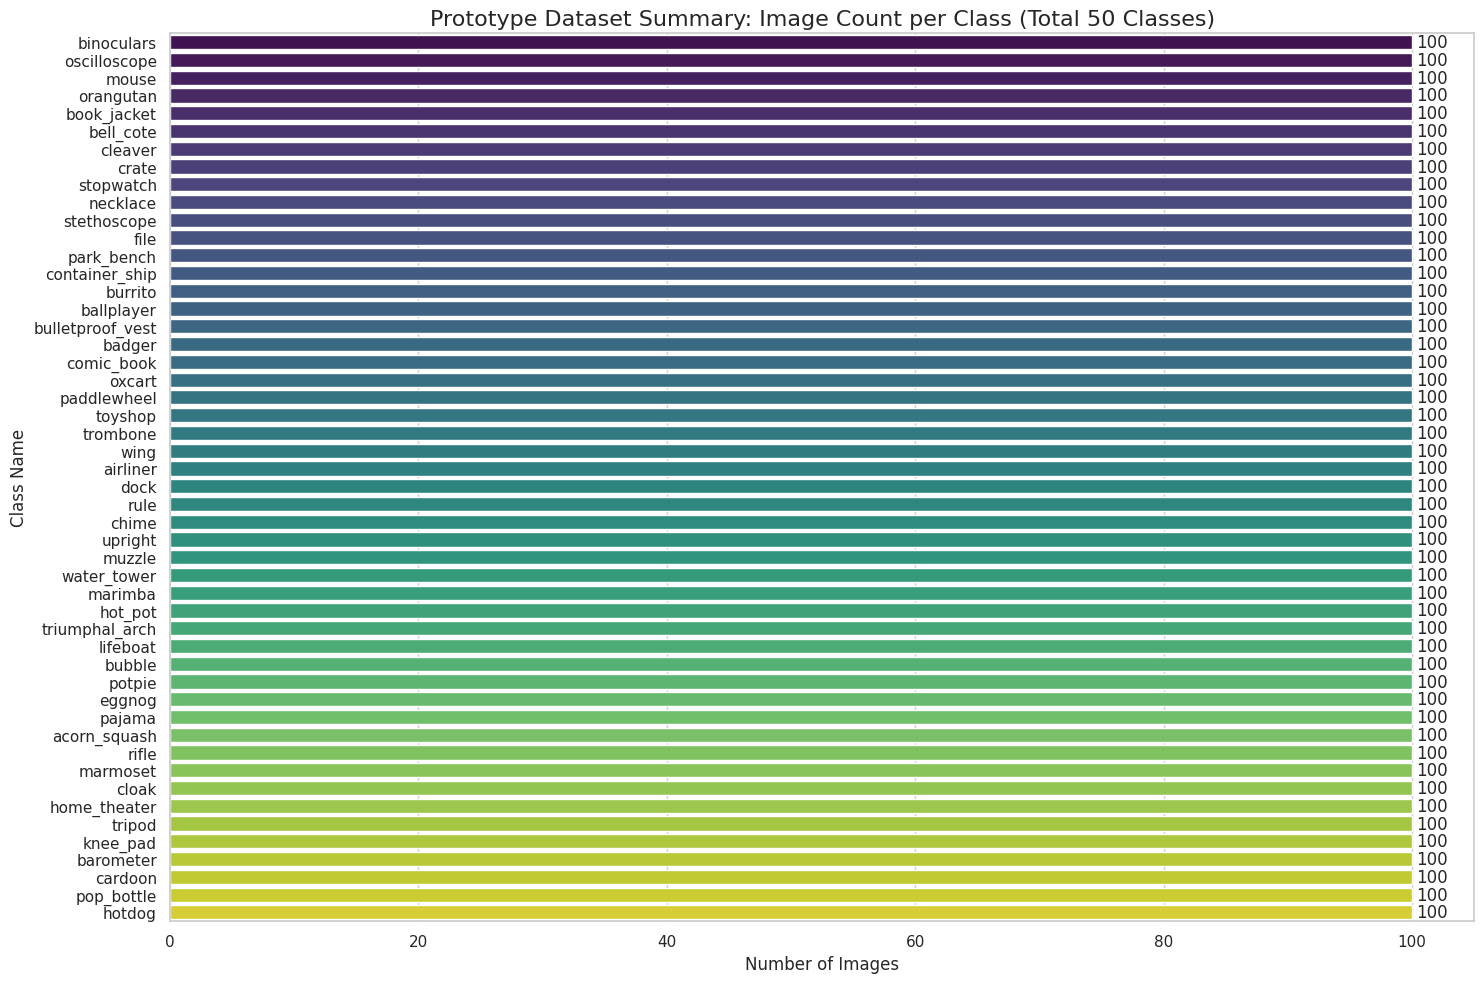

In [4]:
# Convert the stats list to a Pandas DataFrame
df_stats = pd.DataFrame(subset_stats)

# --- 1. Print Statistics ---
print("--- Prototype Dataset Statistics ---")
print(f"Total Classes: {len(df_stats)}")
print(f"Total Images:  {df_stats['image_count'].sum()}")
print(f"Images per Class (Target): {NUM_SAMPLES_PER_CLASS}")
print(f"Images per Class (Actual Mean): {df_stats['image_count'].mean():.2f}")

print("\n--- Class Breakdown ---")
# Set pandas to display all rows (since 50 is manageable)
pd.set_option('display.max_rows', None)
print(df_stats)
pd.reset_option('display.max_rows')


# --- 2. Create Visualization ---
print("\nGenerating dataset visualization...")

plt.figure(figsize=(15, 10))  # Increase figure size
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(
    x='image_count',
    y='class_name',
    data=df_stats.sort_values('image_count', ascending=False), # Sort for a cleaner look
    palette='viridis'
)

ax.set_title(f'Prototype Dataset Summary: Image Count per Class (Total {len(df_stats)} Classes)', fontsize=16)
ax.set_xlabel('Number of Images', fontsize=12)
ax.set_ylabel('Class Name', fontsize=12)

# Add value labels to the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

In [5]:


# --- 1. Define the Basic Residual Block ---
# This is the standard 2-layer block used in ResNet-18 and ResNet-34
class BasicBlock(nn.Module):
    expansion = 1 # Output channels = input channels

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First conv layer: 3x3, apply stride here
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        # Second conv layer: 3x3
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # Shortcut (identity) connection
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # If we downsampled, we must apply the same to the identity
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the identity to the output (the "residual" connection)
        out += identity
        out = self.relu(out)

        return out


# --- 2. Define the Main ResNet Architecture ---
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        
        # self.in_planes tracks the number of input channels for each stage
        self.in_planes = 64
        
        # --- Stem (conv1) ---
        # Same as ResNet-34: 7x7 conv, stride 2, 64 filters
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # --- Residual Stages (conv2_x to conv5_x) ---
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # --- Classifier Head ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # --- Initialize Weights ---
        # Crucial for training from scratch
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride=1):
        """Helper function to create a residual stage."""
        downsample = None
        
        # The first block of a stage handles downsampling (if stride != 1)
        # or channel changes
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # Add the first block (which might have downsampling)
        layers.append(block(self.in_planes, planes, stride, downsample))
        
        # Update in_planes for the rest of the blocks in this stage
        self.in_planes = planes * block.expansion
        
        # Add the remaining blocks
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming He initialization, a standard for ReLU nets
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Stages
        x = self.layer1(x) # conv2_x
        x = self.layer2(x) # conv3_x
        x = self.layer3(x) # conv4_x
        x = self.layer4(x) # conv5_x

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# --- 3. Create the ResNet-36 Model ---
def CustomResNet36(num_classes=50):
    """
    Constructs a ResNet-36 model.
    ResNet-34 has layers = [3, 4, 6, 3]
    We add one block (2 layers) to the final stage.
    Our ResNet-36 has layers = [3, 4, 6, 4]
    """
    layers = [3, 4, 6, 4]
    
    # Layer Count:
    # conv1:       1
    # conv2_x: 3*2 = 6
    # conv3_x: 4*2 = 8
    # conv4_x: 6*2 = 12
    # conv5_x: 4*2 = 8
    # fc:          1
    # TOTAL  = 1 + 6 + 8 + 12 + 8 + 1 = 36 layers
    
    model = ResNet(BasicBlock, layers, num_classes=num_classes)
    return model

In [6]:
# This is the variable from your previous data creation step
NUM_CLASSES_TO_SELECT = 50 

# Instantiate your custom ResNet-36
# NOTE: This must be run in a cell *after* the cell above
model_36 = CustomResNet36(num_classes=NUM_CLASSES_TO_SELECT)

# Print a summary to verify the architecture (optional, but recommended)
# If you don't have torchsummary, just printing the model is fine:
# print(model_36)

try:
    from torchsummary import summary
    # Assuming standard ImageNet input size
    summary(model_36, (3, 224, 224), device='cpu')
except ImportError:
    print("torchsummary not found. Printing model structure instead:\n")
    print(model_36)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

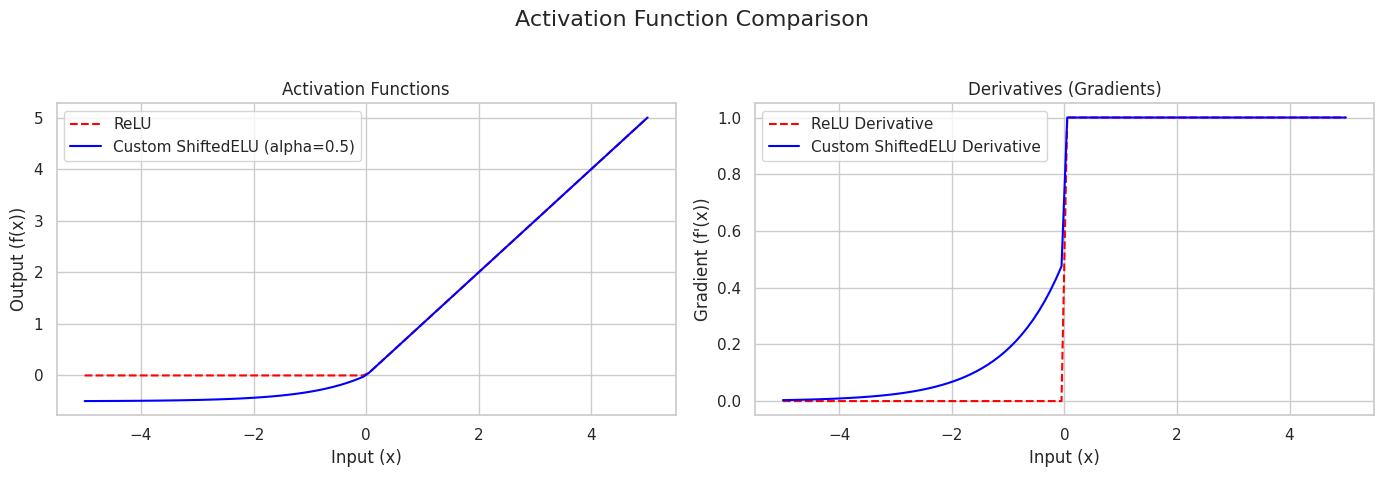

In [7]:


# --- 1. Define the Custom Activation Function ---
class ShiftedELU(nn.Module):
    """
    Shifted Exponential Linear Unit (SELU).
    A custom activation function for this exercise.
    
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    
    Parameters:
        - alpha: a small positive constant. Default is 0.1
    """
    def __init__(self, alpha=0.1, inplace=False):
        super(ShiftedELU, self).__init__()
        self.alpha = alpha
        self.inplace = inplace

    def forward(self, x):
        mask = (x >= 0).float()
        positive_part = x * mask
        negative_part = self.alpha * (torch.exp(torch.min(x, torch.zeros_like(x))) - 1) * (1 - mask)
        
        return positive_part + negative_part

    def __repr__(self):
        return f'ShiftedELU(alpha={self.alpha})'


# --- 2. Visualize the Activation Function ---
def visualize_activations():
    """
    Graphs the custom SELU vs. standard ReLU and their derivatives.
    """
    # Define the input range
    x = torch.linspace(-5, 5, 100, requires_grad=True)
    
    # Get outputs from both activation functions
    relu_func = nn.ReLU()
    selu_func = ShiftedELU(alpha=0.5) # Using a larger alpha for visibility
    
    y_relu = relu_func(x.clone())
    y_selu = selu_func(x.clone())
    
    # Calculate gradients (derivatives)
    y_relu.sum().backward()
    grad_relu = x.grad.clone()
    x.grad.zero_() # Reset gradients
    
    y_selu.sum().backward()
    grad_selu = x.grad.clone()
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Activation Function Comparison', fontsize=16)
    
    # Plot 1: The functions themselves
    ax1.plot(x.detach().numpy(), y_relu.detach().numpy(), label='ReLU', color='red', linestyle='--')
    ax1.plot(x.detach().numpy(), y_selu.detach().numpy(), label='Custom ShiftedELU (alpha=0.5)', color='blue')
    ax1.set_title('Activation Functions')
    ax1.set_xlabel('Input (x)')
    ax1.set_ylabel('Output (f(x))')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: The derivatives
    ax2.plot(x.detach().numpy(), grad_relu.numpy(), label='ReLU Derivative', color='red', linestyle='--')
    ax2.plot(x.detach().numpy(), grad_selu.numpy(), label='Custom ShiftedELU Derivative', color='blue')
    ax2.set_title('Derivatives (Gradients)')
    ax2.set_xlabel('Input (x)')
    ax2.set_ylabel('Gradient (f\'(x))')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization
visualize_activations()

In [8]:
# --- ResNet Code from previous step, now modified for custom activations ---

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, activation_layer=nn.ReLU):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # Use the provided activation layer
        self.activation = activation_layer()
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out) # Apply activation after addition

        return out


class ResNet(nn.Module):
    # Pass activation_layer to the constructor
    def __init__(self, block, layers, num_classes=1000, activation_layer=nn.ReLU):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.activation_layer = activation_layer # Store for use in _make_layer
        
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.activation = self.activation_layer()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # Pass the activation_layer to the BasicBlock
        layers.append(block(self.in_planes, planes, stride, downsample, activation_layer=self.activation_layer))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, activation_layer=self.activation_layer))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# --- 4. Create the ResNet-36 Model with our Custom Activation ---
def CustomResNet36_With_SELU(num_classes=50):
    """Constructs a ResNet-36 model using our custom ShiftedELU."""
    layers = [3, 4, 6, 4]
    model = ResNet(BasicBlock, layers, num_classes=num_classes, activation_layer=ShiftedELU)
    return model

# --- Example of creating the model ---
NUM_CLASSES_TO_SELECT = 50 # From your data creation step
model_36_selu = CustomResNet36_With_SELU(num_classes=NUM_CLASSES_TO_SELECT)

# Print the first block to verify the activation function has been replaced
print("--- Architecture with Custom Activation ---")
print(model_36_selu.layer1[0])

--- Architecture with Custom Activation ---
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ShiftedELU(alpha=0.1)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# --- IMPORTS (from Cell 1, but we need tqdm) ---
from tqdm import tqdm # Use standard tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



print("--- ENVIRONMENT CHECK ---")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device Count: {torch.cuda.device_count()}")
    print(f"Current Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CUDA IS NOT AVAILABLE. TRAINING ON CPU.")
print("---------------------------")



# --- 1. Define Custom Activation Function ---
class ShiftedELU(nn.Module):
    def __init__(self, alpha=0.1, inplace=False):
        super(ShiftedELU, self).__init__()
        self.alpha = alpha
        self.inplace = inplace

    def forward(self, x):
        mask = (x >= 0).float()
        positive_part = x * mask
        negative_part = self.alpha * (torch.exp(torch.min(x, torch.zeros_like(x))) - 1) * (1 - mask)
        return positive_part + negative_part

    def __repr__(self):
        return f'ShiftedELU(alpha={self.alpha})'


# --- 2. Define Model Architectures ---

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, activation_layer=nn.ReLU):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.activation = activation_layer()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.activation(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.activation(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, activation_layer=nn.ReLU):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.activation_layer = activation_layer
        
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.activation = self.activation_layer()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample, activation_layer=self.activation_layer))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, activation_layer=self.activation_layer))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.activation(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x); x = torch.flatten(x, 1); x = self.fc(x)
        return x

# --- Model Constructors ---
def CustomResNet36_With_SELU(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 4], num_classes=num_classes, activation_layer=ShiftedELU)

def ResNet34_ReLU(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, activation_layer=nn.ReLU)


# --- 3. Configuration ---

# ---!!!--- CHOOSE YOUR MODEL HERE ---!!!---
model_name = "ResNet36_SELU"
# model_name = "ResNet34_ReLU"

# --- Hyperparameters ---
NUM_EPOCHS = 5
BATCH_SIZE = 1024
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LR_STEP_SIZE = 2
LR_GAMMA = 0.1
NUM_WORKERS = 16

# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Available GPUs: {torch.cuda.device_count()}")


# --- 4. NEW Data Loading (Option 2) ---

# ---!!! IMPORTANT CHANGE !!!---
# Point to the NEW directory on /scratch
# (Use your actual username)
DATA_DIR = '/scratch/amanjarl/imagenet_full_split'
# ---!!! IMPORTANT CHANGE !!!---

# Standard ImageNet transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create a dictionary of transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]),
}

# --- This is the new data loading logic ---
print(f"Loading datasets from: {DATA_DIR}")
try:
    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                      for x in ['train', 'val', 'test']}
    
    dataloaders = {x: DataLoader(image_datasets[x], 
                                 batch_size=BATCH_SIZE, 
                                 shuffle=(x == 'train'), 
                                 num_workers=NUM_WORKERS)
                   for x in ['train', 'val', 'test']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes
    NUM_CLASSES = len(class_names)
    
    print(f"Num classes: {NUM_CLASSES}")
    print(f"Train size: {dataset_sizes['train']}, Val size: {dataset_sizes['val']}, Test size: {dataset_sizes['test']}")

except FileNotFoundError:
    print(f"Error: Data directory {DATA_DIR} not found.")
    print("Please check the path and ensure your 'sbatch' job finished correctly.")
    raise
# --- End of new data loading logic ---


# --- 5. Initialize Model, Optimizer, etc. ---
print(f"Initializing model: {model_name}")

if model_name == "ResNet36_SELU":
    model = CustomResNet36_With_SELU(num_classes=NUM_CLASSES)
else:
    model = ResNet34_ReLU(num_classes=NUM_CLASSES)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs via nn.DataParallel.")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=LEARNING_RATE, 
                      momentum=MOMENTUM, 
                      weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)


# --- 6. Helper Functions (Accuracy, Plotting) ---

def calculate_accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def plot_curves(history, model_name):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Top-1 Acc')
    plt.plot(history['val_acc'], label='Validation Top-1 Acc')
    plt.title(f'Accuracy Curves - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_curves.png')
    plt.show()

    
# --- 7. The Training Loop ---

def run_training(model, model_name):
    print(f"\n--- Starting Training for {model_name} ---")
    start_time = time.time()
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print('-' * 20)

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_top1 = 0.0
        
        pbar = tqdm(dataloaders['train'], desc="Training")
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            acc1, _ = calculate_accuracy(outputs, labels, topk=(1, 5))
            running_top1 += acc1[0].item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item(), 'acc1': acc1[0].item()})

        scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_top1 / dataset_sizes['train']
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        running_top1 = 0.0
        running_top5 = 0.0
        
        pbar_val = tqdm(dataloaders['val'], desc="Validating")
        with torch.no_grad():
            for inputs, labels in pbar_val:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                acc1, acc5 = calculate_accuracy(outputs, labels, topk=(1, 5))
                running_top1 += acc1[0].item() * inputs.size(0)
                running_top5 += acc5[0].item() * inputs.size(0)
        
        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_top1 / dataset_sizes['val']
        epoch_acc5 = running_top5 / dataset_sizes['val']
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)
        print(f"Val Loss: {epoch_loss:.4f} Top-1 Acc: {epoch_acc:.4f} Top-5 Acc: {epoch_acc5:.4f}")

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # --- 8. Final Test Evaluation ---
    print("\n--- Running Final Test Evaluation ---")
    model.eval()
    test_loss = 0.0
    test_top1 = 0.0
    test_top5 = 0.0
    
    pbar_test = tqdm(dataloaders['test'], desc="Testing")
    with torch.no_grad():
        for inputs, labels in pbar_test:
            inputs = inputs.to(device)
            labels = labels.to(Two(device))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            acc1, acc5 = calculate_accuracy(outputs, labels, topk=(1, 5))
            test_top1 += acc1[0].item() * inputs.size(0)
            test_top5 += acc5[0].item() * inputs.size(0)
            
    final_loss = test_loss / dataset_sizes['test']
    final_top1 = test_top1 / dataset_sizes['test']
    final_top5 = test_top5 / dataset_sizes['test']
    
    print("\n--- FINAL TEST RESULTS ---")
    print(f"Model:     {model_name}")
    print(f"Test Loss: {final_loss:.4f}")
    print(f"Top-1 Acc: {final_top1:.4f} %")
    print(f"Top-5 Acc: {final_top5:.4f} %")
    
    # --- 9. Plot Curves ---
    plot_curves(history, model_name)

# ---!!!--- START THE SCRIPT ---!!!---
run_training(model, model_name)

--- ENVIRONMENT CHECK ---
CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: NVIDIA A100-SXM4-80GB
---------------------------
Using device: cuda
Available GPUs: 1
Loading datasets from: /scratch/amanjarl/imagenet_full_split
Num classes: 650
Train size: 767571, Val size: 32500, Test size: 32500
Initializing model: ResNet36_SELU

--- Starting Training for ResNet36_SELU ---

Epoch 1/5
--------------------


Training:   3%|▎         | 88/2999 [02:51<44:20,  1.09it/s, loss=6.38, acc1=0.391]  